In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler

%matplotlib inline

# Set color cycle for all plots
plt.rcParams["axes.prop_cycle"] = cycler(
    color=[plt.get_cmap("Set2")(i) for i in range(9)]
)

## Overview
1. load the data from df_train.csv
2. Extract the numerical features from the data (df_numeric)
3. Find the optimal number of clusters using the elbow method 
4. Apply kMeans and compare the shilouette score
 - df_numeric
 - standardized df_numeric
 - scaled df_numeric
 - standardized and scaled df_numeric

## 1. load the data

In [4]:
from utils import get_df_description

# load df
df = pd.read_csv('../datasets/df_train.csv')

# load json file
description_json = json.load(open('df_train_description.json', 'r'))
description_json_df = pd.DataFrame(description_json)

# get df_description
df_description = get_df_description(df, description_json_df)
df_description

,column,dtype,missing_values,source,description
0,customer_unique_id,object,0,df_customers,PK
1,frequency,int64,0,Calculated,number of orders
2,repeater,int64,0,Calculated,"1:repeater, 0:non-repeater"
3,fo_order_id,object,0,df_orders,FK
4,fo_customer_id,object,0,df_orders,FK (first order's customer_id)
5,fo_order_status,object,0,df_orders,
6,fo_order_purchase_timestamp,object,0,df_orders,
7,fo_order_approved_at,object,0,df_orders,
8,fo_order_delivered_carrier_date,object,0,df_orders,
9,fo_order_delivered_customer_date,object,0,df_orders,


## 2. Prepare df_numeric

In [5]:
## Selecting numeric columns
df_numeric = df.select_dtypes(include=['number']).dropna()
print(df_numeric.shape)
df_numeric.head()

(3456, 12)


,frequency,repeater,customer_zip_code_prefix,recency,monetary,fo_payment_value,fo_is_daytime,fo_is_weekday,fo_delivery_delay_days,fo_review_score_mean,fo_voucher_payment_value,fo_voucher_used
19,1,0,72872,114,78.42,78.42,1,1,-15.0,3.0,69.89,1
55,1,0,13273,308,354.87,354.87,1,1,-6.0,3.0,293.54,1
73,1,0,77600,482,109.78,109.78,1,1,-17.0,5.0,31.73,1
165,1,0,3904,113,79.51,79.51,1,1,-21.0,5.0,79.51,1
232,1,0,13920,289,66.91,66.91,1,0,-20.0,4.0,43.92,1


## 3. Find the optimal number of clusters using the elbow method

/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

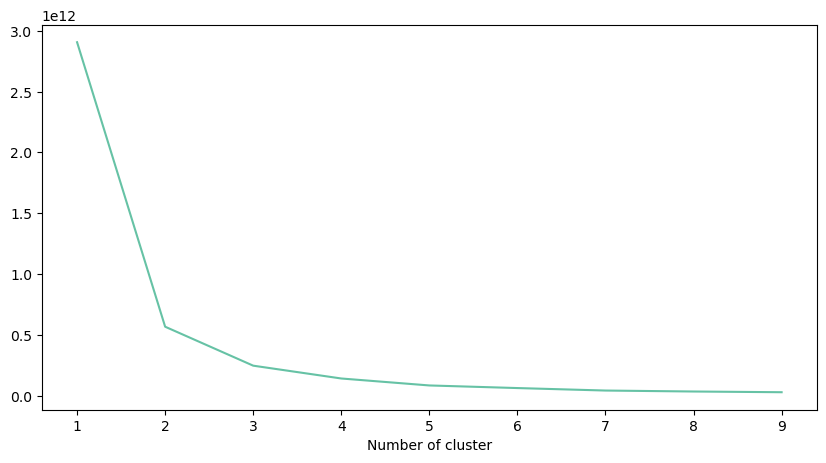

In [6]:
from sklearn.cluster import KMeans

## First of all, we need to know the optimal number of clusters
sse={}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_numeric)
    df_numeric["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

The plot shows that the optimal number of cluster is 3-5. I will use 4 clusters.

## 4. Apply kMeans and compare the shilouette score
 - df_numeric
 - standardized df_numeric
 - scaled df_numeric
 - standardized and scaled df_numeric

In [7]:
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):  # Starting from 2 as there can't be 1 cluster
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(data)
        score = silhouette_score(data, labels)
        silhouette_scores.append((n_clusters, score))

    # Find the number of clusters that gives the highest silhouette score
    optimal_n_clusters, highest_score = max(silhouette_scores, key=lambda item: item[1])
    return optimal_n_clusters, highest_score

In [10]:

from utils import standardize, normalize

kmeans = KMeans(n_clusters=4)
results = []

## 4-1. Original data
optimal_clusters_orig, silhouette_orig = find_optimal_clusters(df_numeric)
results.append(['Original Data', optimal_clusters_orig, silhouette_orig])

# 4-2. Standardized data
df_standardized = standardize(df_numeric)
optimal_clusters_std, silhouette_std = find_optimal_clusters(df_standardized)
results.append(['Standardized Data', optimal_clusters_std, silhouette_std])

# 4-3. Normalized data
df_normalized = normalize(df_numeric)
optimal_clusters_norm, silhouette_norm = find_optimal_clusters(df_normalized)
results.append(['Normalized Data', optimal_clusters_norm, silhouette_norm])

# 4-4. Standardized and normalized data
df_std_norm = normalize(df_standardized)
optimal_clusters_std_norm, silhouette_std_norm = find_optimal_clusters(df_std_norm)
results.append(['Standardized and Normalized Data', optimal_clusters_std_norm, silhouette_std_norm])

results_df = pd.DataFrame(results, columns=['Data Preprocessing', 'Optimal Clusters', 'Silhouette Score'])
results_df


/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yukiogawa/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` wi

,Data Preprocessing,Optimal Clusters,Silhouette Score
0,Original Data,2,0.722181
1,Standardized Data,3,0.541755
2,Normalized Data,3,0.374944
3,Standardized and Normalized Data,3,0.374944


## Conclusion
- Original data has the highest shilouette score, so it's the best.
- We can test standardizing or scaleing not the whole features but only the necessary features to improve the score.